In [27]:
import warnings
import time
import sys
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm
import pandas as pd

In [28]:
PLOT_SHOW=True
PLOT_TYPE = False

time_period = 100
max_iter = int(1e6)
K = time_period

labels = ['Close','Open','High','Low']


def calc_mape(predicted_data, true_data):
    return np.divide(np.sum(np.divide(np.absolute(predicted_data - true_data), true_data), 0), true_data.shape[0])

In [29]:
dataset =  pd.read_excel('ExchangeRates.xlsx', sheet_name='usd-cad')[labels]
dataset = np.array(dataset)

In [30]:
def get_best_num_states(dataset, max_range = 15, time_period= 50, max_iter=1e6):
    likelihoods = np.empty(13)
    aics = np.empty(13)
    bics = np.empty(13)

    for num_states in range(2,max_range):
        
        num_params = num_states**2 + 2*num_states - 1
        
        model = hmm.GaussianHMM(n_components=num_states, covariance_type='full', tol=1e-6, n_iter=max_iter)
        model.fit(dataset[100:,:])
        
        if model.monitor_.iter == max_iter:
            print('max iterations reached. Error')
            sys.exit(1)
        
        likelihoods[num_states-2] = model.score(dataset)
        aics[num_states-2] = -2 * model.score(dataset) + 2 * num_params
        bics[num_states-2] =  -2 * model.score(dataset) +  num_params * np.log(dataset.shape[0])

        plt.plot(range(1,len(aics)+1), aics, label = "AIC")
        plt.plot(range(1,len(bics)+1), bics, label = "BIC")
        plt.xlabel('# of states')
        plt.ylabel('Measure')
        plt.title('Model fit test')
        plt.show()


    opt_states = np.argmin(bics) + 2

    return opt_states

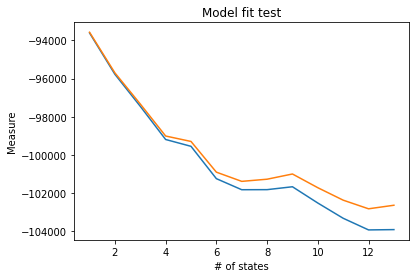

Optimum number of states are 13


In [31]:
likelihoods = np.empty(13)
aics = np.empty(13)
bics = np.empty(13)

for num_states in range(2,15):
        num_params = num_states**2 + num_states
        model = hmm.GaussianHMM(n_components=num_states, covariance_type='full', tol=0.0001, n_iter=max_iter)
        model.fit(dataset[time_period:,:])
        if model.monitor_.iter == time_period:
            print('Increase number of iterations')
            sys.exit(1)
        likelihoods[num_states-2] = model.score(dataset)
        aics[num_states-2] = -2 * model.score(dataset) + 2 * num_params
        bics[num_states-2] =  -2 * model.score(dataset) +  num_params * np.log(dataset.shape[0])

plt.plot(range(1,len(aics)+1), aics, label = "AIC")
plt.plot(range(1,len(bics)+1), bics, label = "BIC")
plt.xlabel('# of states')
plt.ylabel('Measure')
plt.title('Optimal states test USD-CAD')
plt.legend()
plt.show()
    
opt_states = np.argmin(bics) + 2
print('Optimum number of states are {}'.format(opt_states))

In [25]:
predicted_stock_data = np.empty([0,dataset.shape[1]])

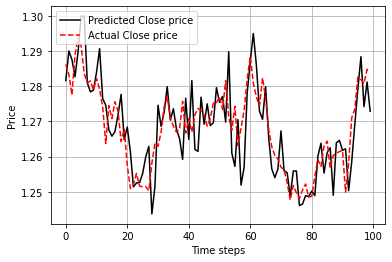

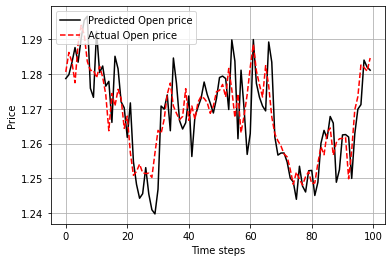

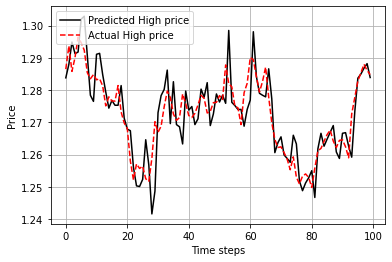

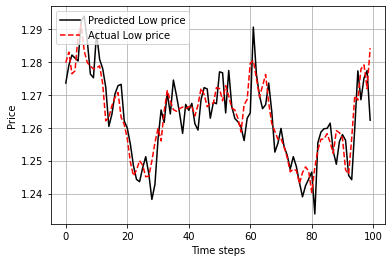

In [26]:

for idx in reversed(range(time_period)):
    train_dataset = dataset[idx + 1:,:]
    test_data = dataset[idx,:]; 
    num_examples = train_dataset.shape[0]
    if idx == time_period - 1:
        model = hmm.GaussianHMM(n_components=opt_states, covariance_type='full', tol=0.0001, n_iter=max_iter, init_params='stmc')
    else:
        # Retune the model by using the HMM paramters from the previous iterations as the prior
        model = hmm.GaussianHMM(n_components=opt_states, covariance_type='full', tol=0.0001, n_iter=max_iter, init_params='')
        model.transmat_ = transmat_retune_prior 
        model.startprob_ = startprob_retune_prior
        model.means_ = means_retune_prior
        model.covars_ = covars_retune_prior

    model.fit(np.flipud(train_dataset))

    transmat_retune_prior = model.transmat_
    startprob_retune_prior = model.startprob_
    means_retune_prior = model.means_
    covars_retune_prior = model.covars_

    if model.monitor_.iter == max_iter:
        print('Increase number of iterations')
        sys.exit(1)


    iters = 1
    past_likelihood = []
    curr_likelihood = model.score(np.flipud(train_dataset[0:K - 1, :]))
    while iters < num_examples / K - 1:
        past_likelihood = np.append(past_likelihood, model.score(np.flipud(train_dataset[iters:iters + K - 1, :])))
        iters = iters + 1
    likelihood_diff_idx = np.argmin(np.absolute(past_likelihood - curr_likelihood))
    predicted_change = train_dataset[likelihood_diff_idx,:] - train_dataset[likelihood_diff_idx + 1,:]
    predicted_stock_data = np.vstack((predicted_stock_data, dataset[idx + 1,:] + predicted_change))


mape = calc_mape(predicted_stock_data, np.flipud(dataset[range(K),:]))

if PLOT_TYPE:
    hdl_p = plt.plot(range(K), predicted_stock_data)
    plt.title('Predicted stock prices')
    plt.legend(iter(hdl_p), ('Close','Open','High','Low'))
    plt.xlabel('Time steps')
    plt.ylabel('Price')
    plt.figure()
    hdl_a = plt.plot(range(K),np.flipud(dataset[range(K),:]))
    plt.title('Actual stock prices')
    plt.legend(iter(hdl_p), ('Close','Open','High','Low'))
    plt.xlabel('Time steps')
    plt.ylabel('Price')
else:
    for i in range(4):
        plt.figure()
        plt.plot(range(K), predicted_stock_data[:,i],'k-', label = 'Predicted '+labels[i]+' price')
        plt.plot(range(K),np.flipud(dataset[range(K),i]),'r--', label = 'Actual '+labels[i]+' price')
        plt.xlabel('Time steps')
        plt.ylabel('Price')
        # plt.title(labels[i]+' price'+ ' for '+stock[:-4])
        plt.grid(True)
        plt.legend(loc = 'upper left')
    

# Create a portfolio using predicted stocks

In [8]:
def plot_cum_return(df,title):
    df = df.reset_index()
    df['index'] = df['index'] + 1
    df.plot(x="index", y = ["cum_actual_pct_change", "cum_predicted_pct_chg"])
    plt.xlabel("Days")
    plt.ylabel("Returns")
    plt.title(title)
    plt.show()

def test_portfolio_strategy(actual, predicted, title):
    actual_df = pd.DataFrame(np.flipud(actual[range(K),:])).rename(columns={i:labels[i] for i in range(len(labels))})
    predicted_df = pd.DataFrame(np.flipud(predicted)).rename(columns={i:labels[i] for i in range(len(labels))})

    df = pd.DataFrame({"actual" : actual_df['Close'], "predicted" : predicted_df['Close']})

    df['actual_pct_chg'] = df['actual'].pct_change()
    df['predicted_pct_chg'] = df['predicted'].pct_change()

    df['portfolio_test_pct_chg'] = df['actual_pct_chg']
    df.loc[df['predicted_pct_chg'] < 0, "portfolio_test_pct_chg"] = 0

    df.loc[df['predicted_pct_chg'] < 0, "predicted_pct_chg"] = 0

    df['cum_actual_pct_change'] = (df['actual_pct_chg'] + 1).cumprod()
    df['cum_predicted_pct_chg'] = (df['portfolio_test_pct_chg'] + 1).cumprod()

    print(df['cum_actual_pct_change'])
    print(df['cum_predicted_pct_chg'])

    plot_cum_return(df, title)


0          NaN
1     0.997823
2     0.993236
3     1.002099
4     1.006064
        ...   
95    0.997201
96    0.996657
97    0.995802
98    0.998912
99    0.998523
Name: cum_actual_pct_change, Length: 100, dtype: float64
0          NaN
1     0.997823
2     0.997823
3     1.006727
4     1.006727
        ...   
95    1.042664
96    1.042664
97    1.041770
98    1.045023
99    1.045023
Name: cum_predicted_pct_chg, Length: 100, dtype: float64


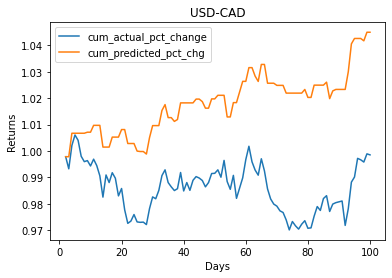

In [9]:
test_portfolio_strategy(dataset, predicted_stock_data, 'USD-CAD')

In [10]:
# d = pd.DataFrame(np.flipud(dataset[range(K),:])).rename(columns={i:labels[i] for i in range(len(labels))})
# p = pd.DataFrame(np.flipud(predicted_stock_data)).rename(columns={i:labels[i] for i in range(len(labels))})

# df = pd.DataFrame({"actual" : d['Close'], "predicted" : p['Close']})

# df['actual_pct_chg'] = df['actual'].pct_change()
# df['predicted_pct_chg'] = df['predicted'].pct_change()

# print((df['actual_pct_chg'] + 1).cumprod())
# print((df.loc[df['predicted_pct_chg'] > 0, "predicted_pct_chg"] + 1).cumprod())


# Run for the currencies USD-JPY

In [11]:
dataset =  pd.read_excel('ExchangeRates.xlsx', sheet_name='usd-jpy')[labels]
dataset = np.array(dataset)

Optimum number of states are 14


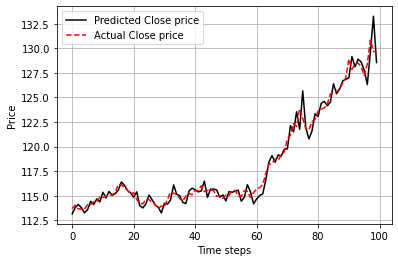

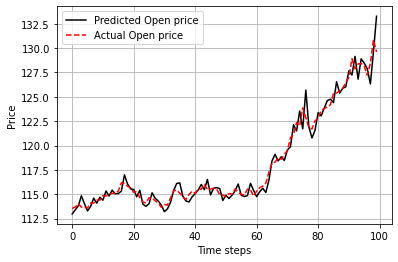

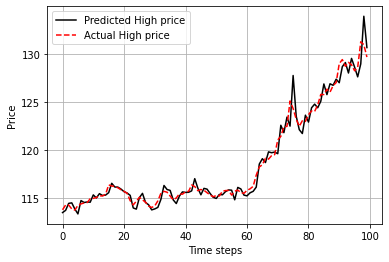

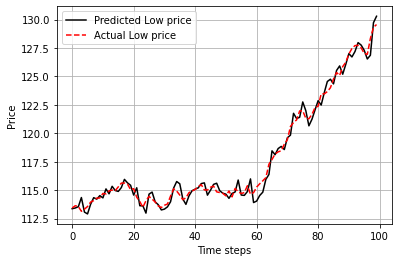

In [12]:
likelihoods = np.empty(13)
aics = np.empty(13)
bics = np.empty(13)

for num_states in range(2,15):
        num_params = num_states**2 + num_states
        model = hmm.GaussianHMM(n_components=num_states, covariance_type='full', tol=0.0001, n_iter=max_iter)
        model.fit(dataset[time_period:,:])
        if model.monitor_.iter == time_period:
            print('Increase number of iterations')
            sys.exit(1)
        likelihoods[num_states-2] = model.score(dataset)
        aics[num_states-2] = -2 * model.score(dataset) + 2 * num_params
        bics[num_states-2] =  -2 * model.score(dataset) +  num_params * np.log(dataset.shape[0])

plt.plot(range(1,len(aics)+1), aics, label = "AIC")
plt.plot(range(1,len(bics)+1), bics, label = "BIC")
plt.xlabel('# of states')
plt.ylabel('Measure')
plt.title('Optimal states test USD-JPY')
plt.legend()
plt.show()
    
opt_states = np.argmin(bics) + 2
print('Optimum number of states are {}'.format(opt_states))

predicted_stock_data = np.empty([0,dataset.shape[1]])


for idx in reversed(range(time_period)):
    train_dataset = dataset[idx + 1:,:]
    test_data = dataset[idx,:]; 
    num_examples = train_dataset.shape[0]
    if idx == time_period - 1:
        model = hmm.GaussianHMM(n_components=opt_states, covariance_type='full', tol=0.0001, n_iter=max_iter, init_params='stmc')
    else:
        # Retune the model by using the HMM paramters from the previous iterations as the prior
        model = hmm.GaussianHMM(n_components=opt_states, covariance_type='full', tol=0.0001, n_iter=max_iter, init_params='')
        model.transmat_ = transmat_retune_prior 
        model.startprob_ = startprob_retune_prior
        model.means_ = means_retune_prior
        model.covars_ = covars_retune_prior

    model.fit(np.flipud(train_dataset))

    transmat_retune_prior = model.transmat_
    startprob_retune_prior = model.startprob_
    means_retune_prior = model.means_
    covars_retune_prior = model.covars_

    if model.monitor_.iter == max_iter:
        print('Increase number of iterations')
        sys.exit(1)


    iters = 1
    past_likelihood = []
    curr_likelihood = model.score(np.flipud(train_dataset[0:K - 1, :]))
    while iters < num_examples / K - 1:
        past_likelihood = np.append(past_likelihood, model.score(np.flipud(train_dataset[iters:iters + K - 1, :])))
        iters = iters + 1
    likelihood_diff_idx = np.argmin(np.absolute(past_likelihood - curr_likelihood))
    predicted_change = train_dataset[likelihood_diff_idx,:] - train_dataset[likelihood_diff_idx + 1,:]
    predicted_stock_data = np.vstack((predicted_stock_data, dataset[idx + 1,:] + predicted_change))


mape = calc_mape(predicted_stock_data, np.flipud(dataset[range(K),:]))

if PLOT_TYPE:
    hdl_p = plt.plot(range(K), predicted_stock_data)
    plt.title('Predicted stock prices')
    plt.legend(iter(hdl_p), ('Close','Open','High','Low'))
    plt.xlabel('Time steps')
    plt.ylabel('Price')
    plt.figure()
    hdl_a = plt.plot(range(K),np.flipud(dataset[range(K),:]))
    plt.title('Actual stock prices')
    plt.legend(iter(hdl_p), ('Close','Open','High','Low'))
    plt.xlabel('Time steps')
    plt.ylabel('Price')
else:
    for i in range(4):
        plt.figure()
        plt.plot(range(K), predicted_stock_data[:,i],'k-', label = 'Predicted '+labels[i]+' price')
        plt.plot(range(K),np.flipud(dataset[range(K),i]),'r--', label = 'Actual '+labels[i]+' price')
        plt.xlabel('Time steps')
        plt.ylabel('Price')
        # plt.title(labels[i]+' price'+ ' for '+stock[:-4])
        plt.grid(True)
        plt.legend(loc = 'upper left')
    

0          NaN
1     1.002990
2     0.999736
3     0.999384
4     0.999208
        ...   
95    1.118997
96    1.129551
97    1.150836
98    1.140721
99    1.139842
Name: cum_actual_pct_change, Length: 100, dtype: float64
0          NaN
1     1.002990
2     1.002990
3     1.002990
4     1.002814
        ...   
95    1.107762
96    1.118210
97    1.139280
98    1.139280
99    1.139280
Name: cum_predicted_pct_chg, Length: 100, dtype: float64


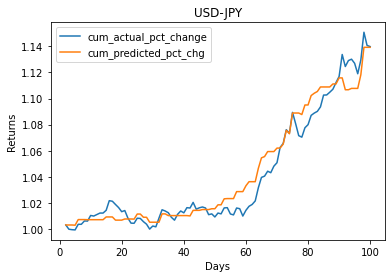

In [13]:
test_portfolio_strategy(dataset, predicted_stock_data, 'USD-JPY')

# Run for the currencies USD-SGD

In [14]:
dataset =  pd.read_excel('ExchangeRates.xlsx', sheet_name='usd-sgd')[labels]
dataset = np.array(dataset)

Optimum number of states are 13


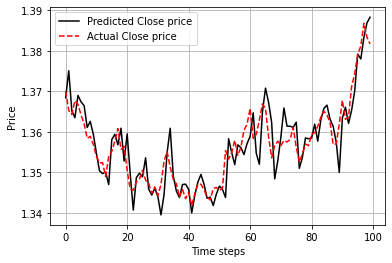

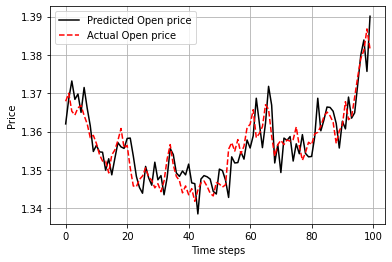

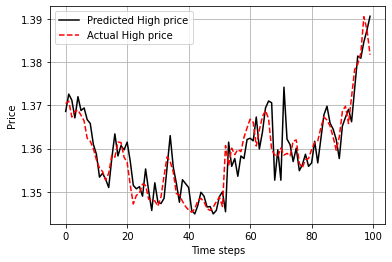

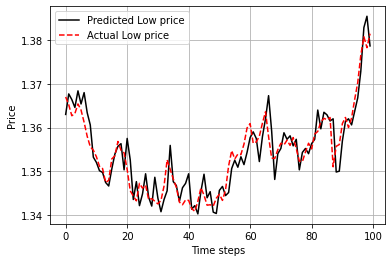

In [15]:
likelihoods = np.empty(13)
aics = np.empty(13)
bics = np.empty(13)

for num_states in range(2,15):
        num_params = num_states**2 + num_states
        model = hmm.GaussianHMM(n_components=num_states, covariance_type='full', tol=0.0001, n_iter=max_iter)
        model.fit(dataset[time_period:,:])
        if model.monitor_.iter == time_period:
            print('Increase number of iterations')
            sys.exit(1)
        likelihoods[num_states-2] = model.score(dataset)
        aics[num_states-2] = -2 * model.score(dataset) + 2 * num_params
        bics[num_states-2] =  -2 * model.score(dataset) +  num_params * np.log(dataset.shape[0])

plt.plot(range(1,len(aics)+1), aics, label = "AIC")
plt.plot(range(1,len(bics)+1), bics, label = "BIC")
plt.xlabel('# of states')
plt.ylabel('Measure')
plt.title('Optimal states test USD-SGD')
plt.legend()
plt.show()
    
opt_states = np.argmin(bics) + 2
print('Optimum number of states are {}'.format(opt_states))

predicted_stock_data = np.empty([0,dataset.shape[1]])


for idx in reversed(range(time_period)):
    train_dataset = dataset[idx + 1:,:]
    test_data = dataset[idx,:]; 
    num_examples = train_dataset.shape[0]
    if idx == time_period - 1:
        model = hmm.GaussianHMM(n_components=opt_states, covariance_type='full', tol=0.0001, n_iter=max_iter, init_params='stmc')
    else:
        # Retune the model by using the HMM paramters from the previous iterations as the prior
        model = hmm.GaussianHMM(n_components=opt_states, covariance_type='full', tol=0.0001, n_iter=max_iter, init_params='')
        model.transmat_ = transmat_retune_prior 
        model.startprob_ = startprob_retune_prior
        model.means_ = means_retune_prior
        model.covars_ = covars_retune_prior

    model.fit(np.flipud(train_dataset))

    transmat_retune_prior = model.transmat_
    startprob_retune_prior = model.startprob_
    means_retune_prior = model.means_
    covars_retune_prior = model.covars_

    if model.monitor_.iter == max_iter:
        print('Increase number of iterations')
        sys.exit(1)


    iters = 1
    past_likelihood = []
    curr_likelihood = model.score(np.flipud(train_dataset[0:K - 1, :]))
    while iters < num_examples / K - 1:
        past_likelihood = np.append(past_likelihood, model.score(np.flipud(train_dataset[iters:iters + K - 1, :])))
        iters = iters + 1
    likelihood_diff_idx = np.argmin(np.absolute(past_likelihood - curr_likelihood))
    predicted_change = train_dataset[likelihood_diff_idx,:] - train_dataset[likelihood_diff_idx + 1,:]
    predicted_stock_data = np.vstack((predicted_stock_data, dataset[idx + 1,:] + predicted_change))


mape = calc_mape(predicted_stock_data, np.flipud(dataset[range(K),:]))

if PLOT_TYPE:
    hdl_p = plt.plot(range(K), predicted_stock_data)
    plt.title('Predicted stock prices')
    plt.legend(iter(hdl_p), ('Close','Open','High','Low'))
    plt.xlabel('Time steps')
    plt.ylabel('Price')
    plt.figure()
    hdl_a = plt.plot(range(K),np.flipud(dataset[range(K),:]))
    plt.title('Actual stock prices')
    plt.legend(iter(hdl_p), ('Close','Open','High','Low'))
    plt.xlabel('Time steps')
    plt.ylabel('Price')
else:
    for i in range(4):
        plt.figure()
        plt.plot(range(K), predicted_stock_data[:,i],'k-', label = 'Predicted '+labels[i]+' price')
        plt.plot(range(K),np.flipud(dataset[range(K),i]),'r--', label = 'Actual '+labels[i]+' price')
        plt.xlabel('Time steps')
        plt.ylabel('Price')
        # plt.title(labels[i]+' price'+ ' for '+stock[:-4])
        plt.grid(True)
        plt.legend(loc = 'upper left')
    

0          NaN
1     0.996497
2     0.995767
3     0.998248
4     0.997591
        ...   
95    1.006569
96    1.008102
97    1.012189
98    1.009707
99    1.008467
Name: cum_actual_pct_change, Length: 100, dtype: float64
0          NaN
1     1.000000
2     1.000000
3     1.000000
4     0.999342
        ...   
95    1.028579
96    1.028579
97    1.032749
98    1.030217
99    1.030217
Name: cum_predicted_pct_chg, Length: 100, dtype: float64


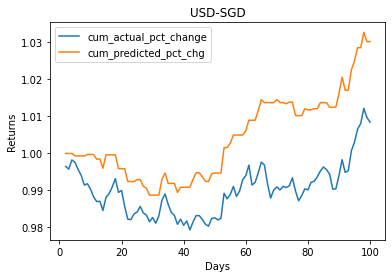

In [16]:
test_portfolio_strategy(dataset, predicted_stock_data, 'USD-SGD')

# Run for the currencies USD-GBP

In [17]:
dataset =  pd.read_excel('ExchangeRates.xlsx', sheet_name='usd-gbp')[labels]
dataset = np.array(dataset)

Optimum number of states are 14


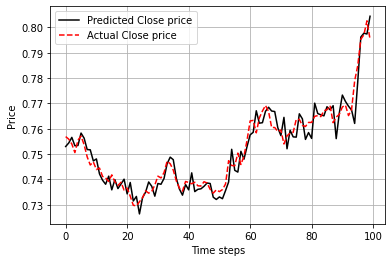

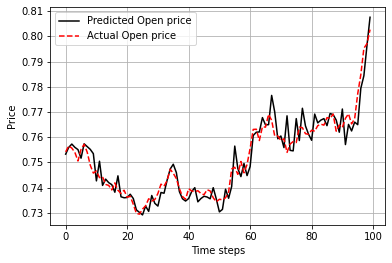

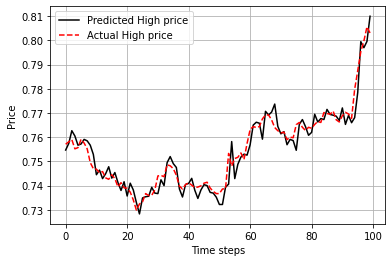

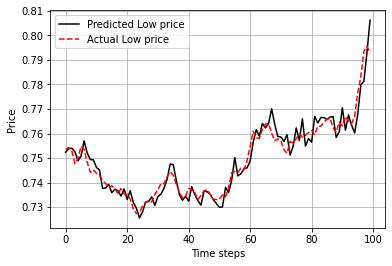

In [18]:
likelihoods = np.empty(13)
aics = np.empty(13)
bics = np.empty(13)

for num_states in range(2,15):
        num_params = num_states**2 + num_states
        model = hmm.GaussianHMM(n_components=num_states, covariance_type='full', tol=0.0001, n_iter=max_iter)
        model.fit(dataset[time_period:,:])
        if model.monitor_.iter == time_period:
            print('Increase number of iterations')
            sys.exit(1)
        likelihoods[num_states-2] = model.score(dataset)
        aics[num_states-2] = -2 * model.score(dataset) + 2 * num_params
        bics[num_states-2] =  -2 * model.score(dataset) +  num_params * np.log(dataset.shape[0])

plt.plot(range(1,len(aics)+1), aics, label = "AIC")
plt.plot(range(1,len(bics)+1), bics, label = "BIC")
plt.xlabel('# of states')
plt.ylabel('Measure')
plt.title('Optimal states test USD-GBP')
plt.legend()
plt.show()
    
opt_states = np.argmin(bics) + 2
print('Optimum number of states are {}'.format(opt_states))

predicted_stock_data = np.empty([0,dataset.shape[1]])


for idx in reversed(range(time_period)):
    train_dataset = dataset[idx + 1:,:]
    test_data = dataset[idx,:]; 
    num_examples = train_dataset.shape[0]
    if idx == time_period - 1:
        model = hmm.GaussianHMM(n_components=opt_states, covariance_type='full', tol=0.0001, n_iter=max_iter, init_params='stmc')
    else:
        # Retune the model by using the HMM paramters from the previous iterations as the prior
        model = hmm.GaussianHMM(n_components=opt_states, covariance_type='full', tol=0.0001, n_iter=max_iter, init_params='')
        model.transmat_ = transmat_retune_prior 
        model.startprob_ = startprob_retune_prior
        model.means_ = means_retune_prior
        model.covars_ = covars_retune_prior

    model.fit(np.flipud(train_dataset))

    transmat_retune_prior = model.transmat_
    startprob_retune_prior = model.startprob_
    means_retune_prior = model.means_
    covars_retune_prior = model.covars_

    if model.monitor_.iter == max_iter:
        print('Increase number of iterations')
        sys.exit(1)


    iters = 1
    past_likelihood = []
    curr_likelihood = model.score(np.flipud(train_dataset[0:K - 1, :]))
    while iters < num_examples / K - 1:
        past_likelihood = np.append(past_likelihood, model.score(np.flipud(train_dataset[iters:iters + K - 1, :])))
        iters = iters + 1
    likelihood_diff_idx = np.argmin(np.absolute(past_likelihood - curr_likelihood))
    predicted_change = train_dataset[likelihood_diff_idx,:] - train_dataset[likelihood_diff_idx + 1,:]
    predicted_stock_data = np.vstack((predicted_stock_data, dataset[idx + 1,:] + predicted_change))


mape = calc_mape(predicted_stock_data, np.flipud(dataset[range(K),:]))

if PLOT_TYPE:
    hdl_p = plt.plot(range(K), predicted_stock_data)
    plt.title('Predicted stock prices')
    plt.legend(iter(hdl_p), ('Close','Open','High','Low'))
    plt.xlabel('Time steps')
    plt.ylabel('Price')
    plt.figure()
    hdl_a = plt.plot(range(K),np.flipud(dataset[range(K),:]))
    plt.title('Actual stock prices')
    plt.legend(iter(hdl_p), ('Close','Open','High','Low'))
    plt.xlabel('Time steps')
    plt.ylabel('Price')
else:
    for i in range(4):
        plt.figure()
        plt.plot(range(K), predicted_stock_data[:,i],'k-', label = 'Predicted '+labels[i]+' price')
        plt.plot(range(K),np.flipud(dataset[range(K),i]),'r--', label = 'Actual '+labels[i]+' price')
        plt.xlabel('Time steps')
        plt.ylabel('Price')
        # plt.title(labels[i]+' price'+ ' for '+stock[:-4])
        plt.grid(True)
        plt.legend(loc = 'upper left')
    

0          NaN
1     0.998679
2     0.996169
3     0.991677
4     0.998150
        ...   
95    1.036993
96    1.050733
97    1.053111
98    1.060378
99    1.050733
Name: cum_actual_pct_change, Length: 100, dtype: float64
0          NaN
1     1.000000
2     0.997486
3     0.997486
4     0.997486
        ...   
95    1.032297
96    1.032297
97    1.034633
98    1.034633
99    1.034633
Name: cum_predicted_pct_chg, Length: 100, dtype: float64


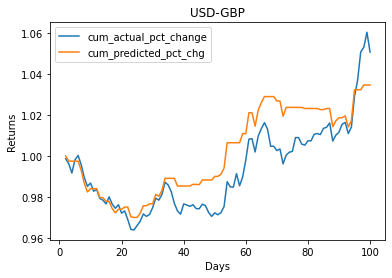

In [19]:
test_portfolio_strategy(dataset, predicted_stock_data, 'USD-GBP')